# Colloid phase diagram 

### Import necessary libraries

In [1]:
import MDAnalysis as mda
import nglview as nv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
##%matplotlib qt
from mpl_toolkits import mplot3d

import scipy.spatial.distance as ssd
from scipy import constants
from scipy import interpolate
from scipy.signal import savgol_filter
from scipy import stats
from scipy.linalg import eig, inv
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.neighbors import KernelDensity

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout as layout

import seaborn as sns

import time
import random

import subprocess

In [2]:
from MDAnalysis.analysis.distances import contact_matrix
import MDAnalysis.transformations as trans

In [3]:
print(mda.__version__)
print(mda.lib)
print(nv.__version__)
print(nx.__version__)

2.1.0
<module 'MDAnalysis.lib' from '/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/lib/__init__.py'>
3.0.3
2.4


## Plot parameters 

In [4]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 14})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

## Define functions

In [5]:
def minimum_image(point,cell):
    
    rc = 1.0/cell
    point = point - cell*np.rint(rc*point)
    return(point)

In [6]:
def centre_of_mass(positions,masses):
    com = np.zeros(3)    
    for i in range(0,len(positions)):
        com += positions[i]*masses[i]
        
    return(com/np.sum(masses))

In [7]:
def calculate_gyration_tensor(positions):
    gyration_tensor = np.zeros((3, 3))
    for i in range(0,len(positions)):
        gyration_tensor += np.outer(positions[i], positions[i])
    return gyration_tensor / len(positions)

# Set the working directory and directory variables

In [8]:
wdir = "./tmp-2.00/"
tdelta = 1e3

# Set the cell parameters 

In [9]:
lx = 92.831777
Vol = lx**3

# Load the trajectory

In [10]:
file = wdir + "dump.3Dcolloid.xyz"
u = mda.Universe(file)
print(u.trajectory)

/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 1
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


<XYZReader ./tmp-2.00/dump.3Dcolloid.xyz with 20001 frames of 388 atoms>


In [11]:
particles = u.select_atoms('type 1')
particles.masses = 1

num_particles = particles.n_atoms
uniform_density = num_particles/Vol
print(num_particles,uniform_density)

388 0.0004849999948630937


## Get the energy time series

In [12]:
filter_window = 1001

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


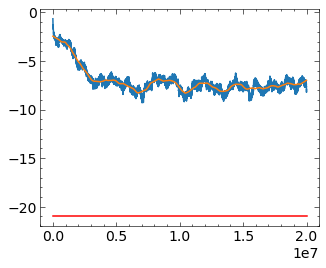

In [13]:
# Load the data and plot with a filter
file = wdir + "energy.dat"
t_ene = np.loadtxt(file)
plt.plot(t_ene[:,0],t_ene[:,1])

flt_t = savgol_filter(t_ene[:,0],filter_window,1)
flt_ene = savgol_filter(t_ene[:,1],filter_window,1,deriv=0)
plt.plot(flt_t,flt_ene)
plt.plot([0,2e7],[-21,-21],color='red')
#plt.xlim(0,1e7)

### Set the time window and check

In [33]:
t0 = 0.75e7
tf = 1.25e7

In [34]:
bin_t0 = int(t0/tdelta)
bin_tf = int(tf/tdelta)

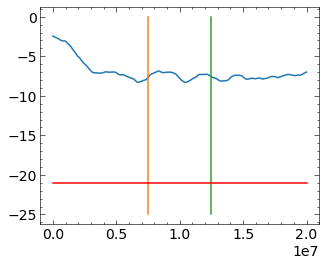

In [35]:
plt.plot(flt_t,flt_ene)
plt.plot([t0,t0],[-25,0])
plt.plot([tf,tf],[-25,0])
plt.plot([0,2e7],[-21,-21],color='red')

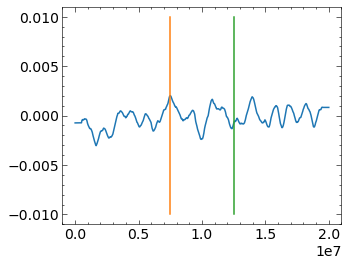

In [36]:
deriv_flt_ene = savgol_filter(t_ene[:,1],filter_window,1,deriv=1)
plt.plot(flt_t,deriv_flt_ene)
plt.plot([t0,t0],[-0.01,0.01])
plt.plot([tf,tf],[-0.01,0.01])

# Time Series Analysis of the Droplet

In [37]:
# Set the cutoff for first sphere coordination
trunc_distance = 7.3#irdf.bins[truncation] 

# Density profile arrays
delta = 0.4
maxd = lx*2
nbins = np.int(maxd/delta)
rad_dist_dropl = np.zeros(nbins)
rad_dist_cryst = np.zeros(nbins)

# Time series lists
time = [] # simulation time
ncls = [] # number of clusters
clsz = [] # cluster sizes
dsiz = [] # droplet size
vsiz = [] # vapour size
drgy = [] # droplet radius of gyration
dasp = [] # droplet asphericity
vden = [] # vapour phase density


frames = 0

In [38]:
# Loop through the xyz frames
for ts in u.trajectory[bin_t0:bin_tf:1]:
    
    if ts.frame%10 == 0:
        print(ts)

    # BOX DIMENSIONS
    ts.dimensions = [lx, lx, lx, 90, 90, 90 ] 
    
    
    #============== IDENTIFY ALL OF THE CLUSTERS ===============
    
    # Generate the adjacancy matrix
    adjmatrix = contact_matrix(particles.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)

    # Generate a graph from the adjacency matrix
    Graph = nx.Graph(adjmatrix)  
    
    # Size of connected components in the graph
    cluster_sizes = [len(c) for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    
     # Largest nucleus
    largest_cluster_size = cluster_sizes[0]      
    
    # List of nodes in every connected component
    cluster_members = [c for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    
    # Number of nuclei connected components
    number_of_clusters = len(cluster_sizes)     
    
    
    #============== ANALYSE THE LARGEST CLUSTER ===============
    
    # PROPERTIES OF THE DROPLET
    # Get the components of the largest cluster
    largest_cluster_indices = list(cluster_members[0])
    droplet = u.atoms[(particles.indices[largest_cluster_indices])]

    # Build a new graph
    adjmatrix_droplet = contact_matrix(droplet.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)
    Graph_droplet = nx.Graph(adjmatrix_droplet)     
    
    # Depth first search for connected nodes
    T = nx.dfs_tree(Graph_droplet, source=0)
    E = list(T.edges())
        
    # Reconstruct the droplet across boundaries
    pos = droplet.positions
    for i in range(0,len(E)):   
        v = pos[E[i][1]] - pos[E[i][0]]
        pos[E[i][1]] = pos[E[i][0]] + minimum_image(v,ts.dimensions[0:3])            
    
    # Droplet centre of mass
    droplet.masses = 1
    com = centre_of_mass(pos,droplet.masses)
    
    # Calculate the gyration tensor
    gyration_tensor = calculate_gyration_tensor(pos - com)

    eVals,eVecs = eig(gyration_tensor)    # Diagonalise
    eVals = eVals.real
    eVals = np.sort(eVals)

    droplet_rgyr = np.sum(eVals)**0.5                                 # Radius of gyration
    droplet_asph = 3/2*eVals[2] - droplet_rgyr**2/2                   # Asphericity
    #droplet_acyl = eVals[1] - eVals[0]                                # Acylindricity
    #droplet_kapa = 3/2 * (np.sum(eVals**2)/np.sum(eVals)**2) - 0.5    # Relative shape anisotropy
       
    # Droplet density profile
    parr = pos[droplet.types == '1']
    for i in range(0,largest_cluster_size):
        v = parr[i] - com
        d = np.sqrt(np.dot(v,v))/delta
        rad_dist_dropl[d.astype(int)] +=1
    
    
    #============== ANALYSE THE VAPOUR PHASE ===============    

    # DENSITIES OF THE PHASES
    vapourdensity = (num_particles - largest_cluster_size) / (Vol - droplet_rgyr**3)
    
    
    
    #============== RECORD THE PROPERTIES ===============       
    time.append(ts.time*tdelta)
    ncls.append(number_of_clusters)
    clsz.extend(cluster_sizes)
    dsiz.append(largest_cluster_size)
    drgy.append(droplet_rgyr)
    dasp.append(droplet_asph)
    vden.append(vapourdensity)
    
    frames += 1

< Timestep 7500 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7510 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7520 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7530 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7540 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7550 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7560 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7570 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7580 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 7590 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >


< Timestep 8330 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8340 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8350 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8360 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8370 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8380 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8390 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8400 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8410 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 8420 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >


< Timestep 9150 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9160 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9170 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9180 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9190 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9200 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9210 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9220 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9230 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9240 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >


< Timestep 9980 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 9990 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10000 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10010 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10020 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10030 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10040 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10050 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10060 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10070 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90. 

< Timestep 10800 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10810 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10820 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10830 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10840 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10850 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10860 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10870 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10880 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 10890 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 11620 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11630 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11640 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11650 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11660 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11670 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11680 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11690 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11700 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 11710 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 12440 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12450 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12460 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12470 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12480 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12490 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >


##  Plot the time series

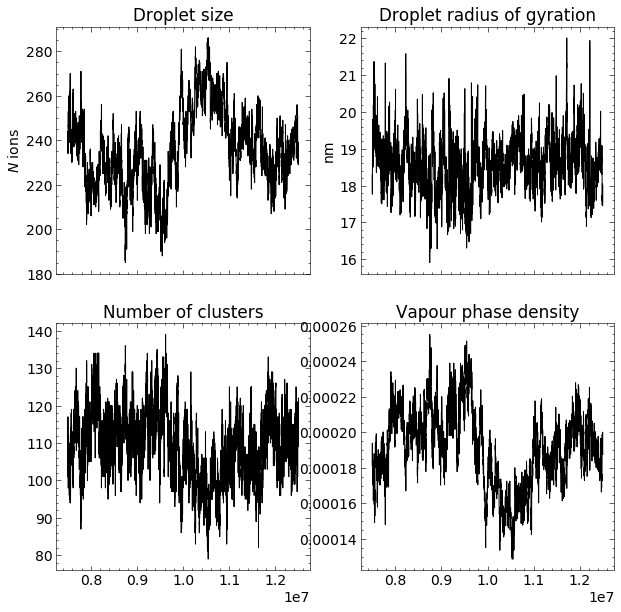

In [39]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(nrows=2, ncols=2, sharex=True,figsize=(10,10))  

# Droplet size
#ax0.set_xlim([intzmin+1.5,intzmax-0.1])
#ax0.set_ylim([0,2.5])
ax0.title.set_text('Droplet size')
ax0.set_ylabel("$N$ ions")
ax0.plot(time,dsiz,'k-',linewidth=1)

# Radius of gyration
#ax1.set_xlim([intzmin,intzmax-0.1])
#ax1.set_ylim([0,1.05])
ax1.title.set_text('Droplet radius of gyration')
ax1.set_ylabel("nm")
ax1.plot(time,drgy,'k-',linewidth=1)

# Number of clusters
#ax2.set_xlim([intzmin,intzmax-0.1])
#ax2.set_ylim([0,2.5])
ax2.title.set_text('Number of clusters')
ax2.set_ylabel("")
ax2.plot(time,ncls,'k-',linewidth=1)

# Vapour phase density
#ax3.set_xlim([intzmin,intzmax-0.1])
#ax3.set_ylim([0,2.5])
ax3.title.set_text('Vapour phase density')
ax3.set_ylabel("")
ax3.plot(time,vden,'k-',linewidth=1)

plt.savefig(wdir+'droplet_timeseries.png',dpi=100)

## Density of the droplet 

In [40]:
binp = np.arange(0,nbins)*delta

dV = 4/3*constants.pi * ((binp+delta)**3-binp**3)
rad_drop = (rad_dist_dropl / frames) / dV 


Text(0, 0.5, 'Reduced density')

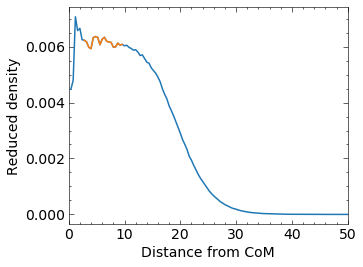

In [47]:
w0 = 6
w1 = 24

binp = binp + delta/2
plt.xlim(0,50)
#plt.ylim(0,65)
plt.plot(binp,rad_drop,'-')
plt.plot(binp[w0:w1],rad_drop[w0:w1],'-')
plt.xlabel("Distance from CoM")
plt.ylabel("Reduced density")



In [48]:
np.savetxt(wdir+'rad_drop.dat',np.column_stack([binp,rad_drop]))

## Print the important properties

In [49]:
with open(wdir+'drop-dens.txt', 'w') as f:
    
    f.write(str(uniform_density) + '\n')
    f.write(str(np.mean(rad_drop[w0:w1])) + '  ' + str(np.std(rad_drop[w0:w1])) + '\n') # droplet mean desnsity
    f.write(str(np.mean(vden)) + '  ' + str(np.std(vden)) + '\n')

print(uniform_density)
print(np.mean(rad_drop[w0:w1]),np.std(rad_drop[w0:w1])) # droplet mean desnsity
print(np.mean(vden),np.std(vden)) # vapour density
print(" ")
print(np.mean(rad_drop[w0:w1])/uniform_density) # droplet mean desnsity
print(np.mean(vden)/uniform_density) # vapour density

0.0004849999948630937
0.006150742311213808 0.00013247140996031488
0.00019195735310292638 2.1686005816217352e-05
 
12.681943044040745
0.39578836110526616


In [53]:
print(np.mean(dsiz))

235.651


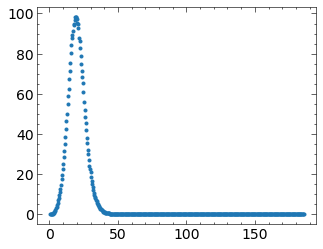

In [65]:
v = 4/3 * constants.pi * binp**3

plt.plot(binp,rad_drop*v,'.')

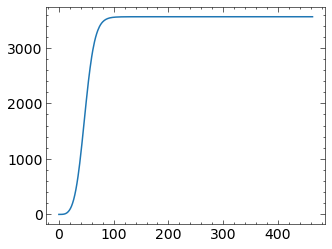

In [66]:
b = np.cumsum(rad_drop*v)
plt.plot(b)

In [50]:
print(np.mean(rad_drop[w0:w1])-np.std(rad_drop[w0:w1]),np.mean(rad_drop[w0:w1])+np.std(rad_drop[w0:w1]))

0.006018270901253493 0.006283213721174123


In [51]:
print(np.mean(drgy),np.mean(drgy)-np.std(drgy),np.mean(drgy)+np.std(drgy))

18.520929082591792 17.775734891290767 19.266123273892816


<ErrorbarContainer object of 3 artists>

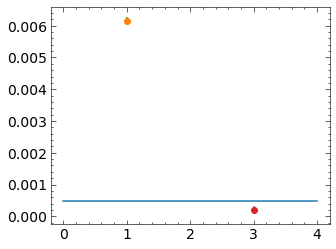

In [52]:
plt.plot([0,4],[uniform_density,uniform_density])
plt.plot(1,np.mean(rad_drop[w0:w1]),'o')
plt.errorbar(1,np.mean(rad_drop[w0:w1]),yerr=np.std(rad_drop[w0:w1]))
plt.plot(3,np.mean(vden),'o')
plt.errorbar(3,np.mean(vden),yerr=np.std(rad_drop[w0:w1]))


# Now Repeat the Exercise to Analyse the Crystal

In [564]:
ct0 = 1.2e7
ctf = 1.85e7

In [565]:
bin_t0 = int(ct0/tdelta)
bin_tf = int(ctf/tdelta)

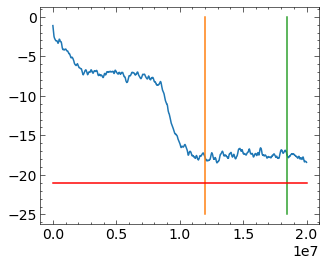

In [566]:
plt.plot(flt_t,flt_ene)
plt.plot([ct0,ct0],[-25,0])
plt.plot([ctf,ctf],[-25,0])
plt.plot([0,2e7],[-21,-21],color='red')
#plt.xlim(0,1e7)

## Time Series Analysis of the Crystal

In [567]:
# Set the cutoff for first sphere coordination
trunc_distance = 7.3#irdf.bins[truncation] 

# Density profile arrays
delta = 0.4
maxd = lx*2
nbins = np.int(maxd/delta)
rad_dist_dropl = np.zeros(nbins)
rad_dist_cryst = np.zeros(nbins)

# Time series lists
time = [] # simulation time
ncls = [] # number of clusters
clsz = [] # cluster sizes
csiz = [] # droplet size
vsiz = [] # vapour size
crgy = [] # droplet radius of gyration
casp = [] # droplet asphericity
vden = [] # vapour phase density


frames = 0

In [568]:
# Loop through the xyz frames
for ts in u.trajectory[bin_t0:bin_tf:10]:
    
    if ts.frame%10 == 0:
        print(ts)

    # BOX DIMENSIONS
    ts.dimensions = [lx, lx, lx, 90, 90, 90 ] 
    
    
    #============== IDENTIFY ALL OF THE CLUSTERS ===============
    
    # Generate the adjacancy matrix
    adjmatrix = contact_matrix(particles.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)

    # Generate a graph from the adjacency matrix
    Graph = nx.Graph(adjmatrix)  
    
    # Size of connected components in the graph
    cluster_sizes = [len(c) for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    
     # Largest nucleus
    largest_cluster_size = cluster_sizes[0]      
    
    # List of nodes in every connected component
    cluster_members = [c for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    
    # Number of nuclei connected components
    number_of_clusters = len(cluster_sizes)     
    
    
    #============== ANALYSE THE LARGEST CLUSTER ===============
    
    # PROPERTIES OF THE CRYSTAL
    # Get the components of the largest cluster
    largest_cluster_indices = list(cluster_members[0])
    crystal = u.atoms[(particles.indices[largest_cluster_indices])]

    # Build a new graph
    adjmatrix_crystal = contact_matrix(crystal.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)
    Graph_crystal = nx.Graph(adjmatrix_crystal)     
    
    # Depth first search for connected nodes
    T = nx.dfs_tree(Graph_crystal, source=0)
    E = list(T.edges())
        
    # Reconstruct the droplet across boundaries
    pos = crystal.positions
    for i in range(0,len(E)):   
        v = pos[E[i][1]] - pos[E[i][0]]
        pos[E[i][1]] = pos[E[i][0]] + minimum_image(v,ts.dimensions[0:3])            
    
    # Droplet centre of mass
    crystal.masses = 1
    com = centre_of_mass(pos,crystal.masses)
    
    # Calculate the gyration tensor
    gyration_tensor = calculate_gyration_tensor(pos - com)

    eVals,eVecs = eig(gyration_tensor)    # Diagonalise
    eVals = eVals.real
    eVals = np.sort(eVals)

    crystal_rgyr = np.sum(eVals)**0.5                                 # Radius of gyration
    crystal_asph = 3/2*eVals[2] - crystal_rgyr**2/2                   # Asphericity
    #droplet_acyl = eVals[1] - eVals[0]                                # Acylindricity
    #droplet_kapa = 3/2 * (np.sum(eVals**2)/np.sum(eVals)**2) - 0.5    # Relative shape anisotropy
       
    # Droplet density profile
    parr = pos[crystal.types == '1']
    for i in range(0,largest_cluster_size):
        v = parr[i] - com
        d = np.sqrt(np.dot(v,v))/delta
        rad_dist_cryst[d.astype(int)] +=1
    
    
    #============== ANALYSE THE VAPOUR PHASE ===============    

    # DENSITIES OF THE PHASES
    vapourdensity = (num_particles - largest_cluster_size) / (Vol - crystal_rgyr**3)
    
    
    
    #============== RECORD THE PROPERTIES ===============       
    time.append(ts.time*tdelta)
    ncls.append(number_of_clusters)
    clsz.extend(cluster_sizes)
    csiz.append(largest_cluster_size)
    crgy.append(crystal_rgyr)
    casp.append(crystal_asph)
    vden.append(vapourdensity)
    
    frames += 1

< Timestep 12000 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12010 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12020 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12030 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12040 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12050 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12060 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12070 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12080 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12090 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 12900 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12910 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12920 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12930 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12940 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12950 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12960 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12970 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12980 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 12990 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 13770 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13780 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13790 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13800 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13810 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13820 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13830 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13840 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13850 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 13860 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 14720 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14730 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14740 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14750 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14760 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14770 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14780 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14790 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14800 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 14810 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 15550 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15560 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15570 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15580 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15590 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15600 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15610 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15620 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15630 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 15640 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 16380 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16390 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16400 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16410 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16420 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16430 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16440 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16450 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16460 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 16470 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 17200 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17210 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17220 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17230 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17240 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17250 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17260 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17270 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17280 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 17290 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

< Timestep 18060 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18070 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18080 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18090 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18100 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18110 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18120 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18130 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18140 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90.     ] >
< Timestep 18150 with unit cell dimensions [92.83178 92.83178 92.83178 90.      90.      90

## Plot the time series

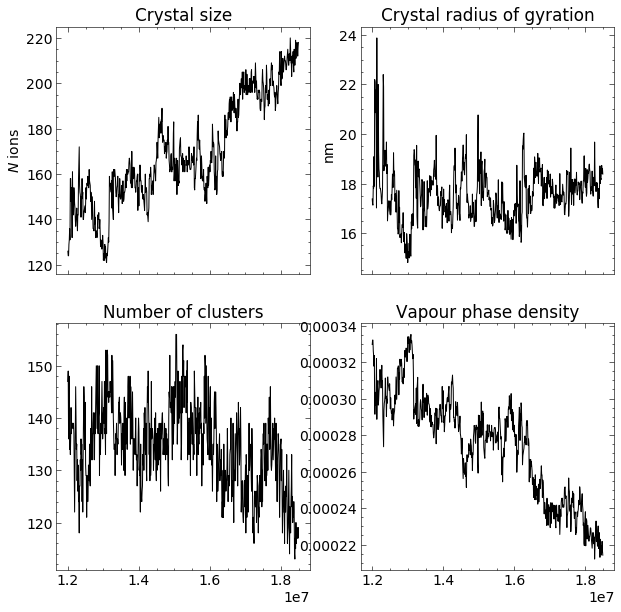

In [569]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(nrows=2, ncols=2, sharex=True,figsize=(10,10))  

# Droplet size
#ax0.set_xlim([intzmin+1.5,intzmax-0.1])
#ax0.set_ylim([0,2.5])
ax0.title.set_text('Crystal size')
ax0.set_ylabel("$N$ ions")
ax0.plot(time,csiz,'k-',linewidth=1)

# Radius of gyration
#ax1.set_xlim([intzmin,intzmax-0.1])
#ax1.set_ylim([0,1.05])
ax1.title.set_text('Crystal radius of gyration')
ax1.set_ylabel("nm")
ax1.plot(time,crgy,'k-',linewidth=1)

# Number of clusters
#ax2.set_xlim([intzmin,intzmax-0.1])
#ax2.set_ylim([0,2.5])
ax2.title.set_text('Number of clusters')
ax2.set_ylabel("")
ax2.plot(time,ncls,'k-',linewidth=1)

# Vapour phase density
#ax3.set_xlim([intzmin,intzmax-0.1])
#ax3.set_ylim([0,2.5])
ax3.title.set_text('Vapour phase density')
ax3.set_ylabel("")
ax3.plot(time,vden,'k-',linewidth=1)

plt.savefig(wdir+'crystal_timeseries.png',dpi=100)

## Density of the Crystal

In [570]:
binp = np.arange(0,nbins)*delta

dV = 4/3*constants.pi * ((binp+delta)**3-binp**3)
rad_cryst= (rad_dist_cryst / frames) / dV 

Text(0, 0.5, 'Reduced density')

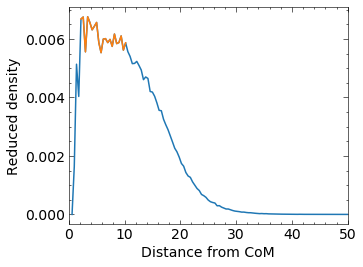

In [575]:
w0 = 4
w1 = 25

binp = binp + delta/2
plt.xlim(0,50)
#plt.ylim(0,65)
plt.plot(binp,rad_cryst,'-')
plt.plot(binp[w0:w1],rad_cryst[w0:w1],'-')
plt.xlabel("Distance from CoM")
plt.ylabel("Reduced density")

In [576]:
with open(wdir+'cryst-dens.txt', 'w') as f:
    
    f.write(str(uniform_density) + '\n')
    f.write(str(np.mean(rad_cryst[w0:w1])) + '  ' + str(np.std(rad_cryst[w0:w1])) + '\n') # droplet mean desnsity
    f.write(str(np.mean(vden)) + '  ' + str(np.std(vden)) + '\n')

print(uniform_density)
print(np.mean(rad_cryst[w0:w1]),np.std(rad_cryst[w0:w1])) # droplet mean desnsity
print(np.mean(vden),np.std(vden)) # vapour density
print(" ")
print(np.mean(rad_cryst[w0:w1])/uniform_density) # droplet mean desnsity
print(np.mean(vden)/uniform_density) # vapour density

0.0004849999948630937
0.006098880471376691 0.0003817481616728437
0.0002745066406037564 2.9279740844548206e-05
 
12.575011414378034
0.5659930794045562


<ErrorbarContainer object of 3 artists>

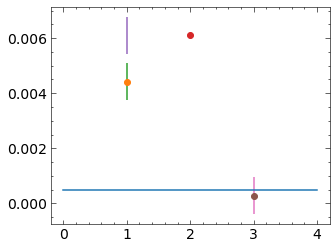

In [577]:
plt.plot([0,4],[uniform_density,uniform_density])
plt.plot(1,np.mean(rad_drop[w0:w1]),'o')
plt.errorbar(1,np.mean(rad_drop[w0:w1]),yerr=np.std(rad_drop[w0:w1]))
plt.plot(2,np.mean(rad_cryst[w0:w1]),'o')
plt.errorbar(1,np.mean(rad_cryst[w0:w1]),yerr=np.std(rad_drop[w0:w1]))
plt.plot(3,np.mean(vden),'o')
plt.errorbar(3,np.mean(vden),yerr=np.std(rad_drop[w0:w1]))